In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
X_data = np.load("X_data.npy")
y_data = np.load("y_data.npy")

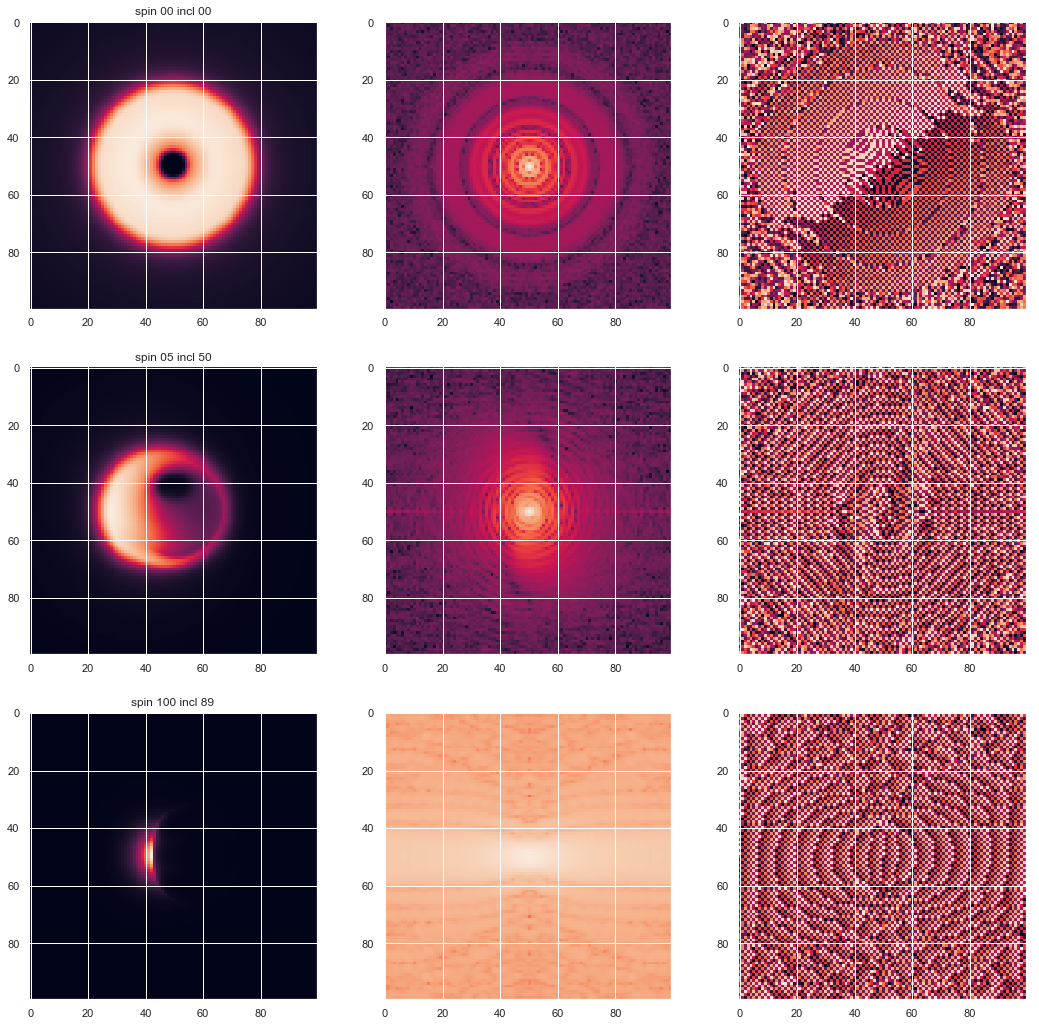

In [4]:
f, ax = plt.subplots(3, 3, figsize=(18,18))
for i,idx in enumerate([0,500,9089]):
    img = X_data[idx,:,:]
    spin, incl = y_data[idx]
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    famp = np.abs(fshift)
    fphi = np.angle(fshift)
    img_back = np.abs(np.fft.ifft2(f))

    ax[i][0].imshow(img)
    ax[i][0].set_title('spin %02d incl %02d'%(spin,incl))
    ax[i][1].imshow(np.log(famp))
    ax[i][2].imshow(fphi)
plt.savefig('/Users/ytcheng/Desktop/FFT_imgs.png', dpi = 200)

In [7]:
X = np.zeros([X_data.shape[0], X_data.shape[1], X_data.shape[2], 2])
for idx in range(len(y_data)):
    img = X_data[idx,:,:]
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    famp = np.log10(np.abs(fshift))
    fphi = np.angle(fshift) / np.pi
    X[idx,:,:,0] = famp
    X[idx,:,:,1] = fphi

kmeans 20 classes

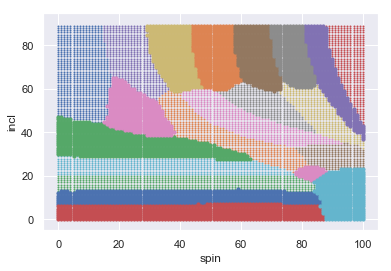

In [14]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(X.reshape([X.shape[0],-1]))
for cls in range(20):
    idx = np.where(kmeans.labels_==cls)[0]
    if cls<10:
        plt.scatter(y_data[idx,0], y_data[idx,1],c='C%d'%(cls%10), s=1)
    else:
        plt.scatter(y_data[idx,0], y_data[idx,1], c='C%d'%(cls%10), s=10)
    plt.xlabel('spin')
    plt.ylabel('incl')
    plt.xlim([-5,105])
    plt.ylim([-5,95])
plt.savefig('/Users/ytcheng/Desktop/kmeans20.png', dpi = 200)

kmeans 10 classes

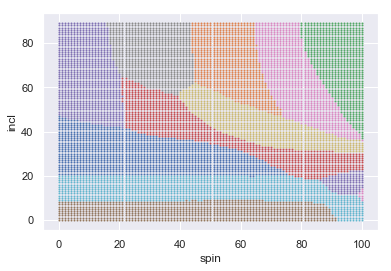

In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X.reshape([X.shape[0],-1]))
for cls in range(10):
    idx = np.where(kmeans.labels_==cls)[0]
    plt.scatter(y_data[idx,0], y_data[idx,1], c='C%d'%(cls), s=1)
plt.xlabel('spin')
plt.ylabel('incl')
plt.savefig('/Users/ytcheng/Desktop/kmeans10.png', dpi = 200)

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

y = kmeans.labels_
n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# one hot
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# model definition
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(100,100,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# training
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()
batch_size = 32
epochs = 10
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        608       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               18874496  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

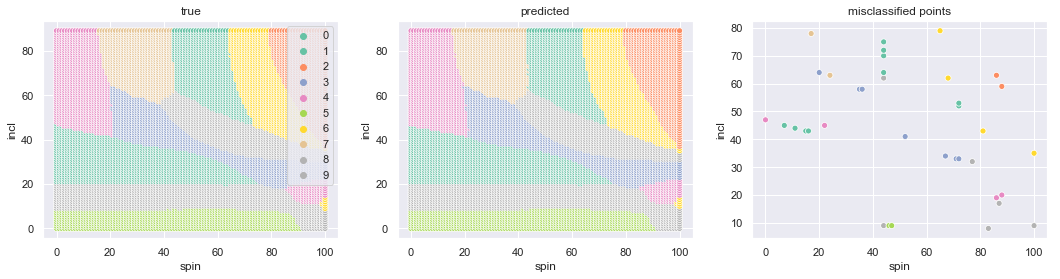

In [23]:
# ypred = model.predict_classes(X)
f, ax = plt.subplots(1, 3, figsize=(18,4))

sns.scatterplot(y_data[:,0], y_data[:,1], hue = y, palette="Set2", ax=ax[0], legend='full')
ax[0].set_xlabel('spin')
ax[0].set_ylabel('incl')
ax[0].set_title('true')

sns.scatterplot(y_data[:,0], y_data[:,1], hue = ypred, palette="Set2", ax=ax[1], legend=False)
ax[1].set_xlabel('spin')
ax[1].set_ylabel('incl')
ax[1].set_title('predicted')

sns.scatterplot(y_data[y!=ypred,0], y_data[y!=ypred,1], 
                hue = ypred[y!=ypred], palette="Set2", ax=ax[2],legend=False)
ax[2].set_xlabel('spin')
ax[2].set_ylabel('incl')
ax[2].set_title('misclassified points')
plt.savefig('/Users/ytcheng/Desktop/FFT_results.png', dpi = 200)

### confirm k-means in real & Fourier space
From Parseval's theorem, total real space power is same as Fourier space, so the k-means based on euclidean distance must give the same clusters

In [21]:
from sklearn.cluster import KMeans

# real space
X = X_data.reshape([X_data.shape[0],-1])
kmeans = KMeans(n_clusters=10.fit(X)

# Fourier space
X = np.zeros([X_data.shape[0], X_data.shape[1], X_data.shape[2], 2])
for idx in range(len(y_data)):
    img = X_data[idx,:,:]
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    X[idx,:,:,0] = np.real(fshift)
    X[idx,:,:,1] = np.imag(fshift)
X = X.reshape([X_data.shape[0], -1])
kmeansf = KMeans(n_clusters=10).fit(X)

Text(0, 0.5, 'incl')

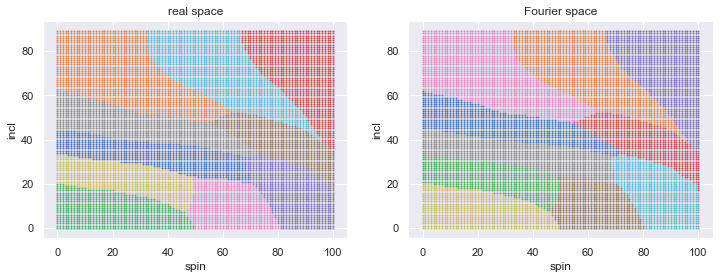

In [38]:
f, ax = plt.subplots(1, 2, figsize=(12,4))
for cls in range(10):
    idx = np.where(kmeans.labels_==cls)[0]
    ax[0].scatter(y_data[idx,0], y_data[idx,1], c='C%d'%(cls), s=1)
    idx = np.where(kmeansf.labels_==cls)[0]
    ax[1].scatter(y_data[idx,0], y_data[idx,1], c='C%d'%(cls), s=1)
ax[0].set_title('real space')
ax[1].set_title('Fourier space')
ax[0].set_xlabel('spin')
ax[1].set_xlabel('spin')
ax[0].set_ylabel('incl')
ax[1].set_ylabel('incl')